In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

import re

In [2]:
result = pd.read_csv('./predictions_basic.csv')

In [3]:
result['actual'].iloc[1]

'[  835476   851057   872021   878302   879948   909638   913202   920626\n   958154   994891  1053690  1083328  1096727  6463658  7167218  7167249\n  9526563  9526886 13842214]'

In [4]:
def list_maker(value):
    # Функция перевода значений датасета result к списку чисел
    # При загрузке датасета поля заполнены строками с лишними символами
    try:
        nums = re.findall('\d+', value)
        nums = list(map(float, nums))
    except:
        return value
    
    return nums

In [5]:
list_maker(result['actual'].iloc[1])[:5]

[835476.0, 851057.0, 872021.0, 878302.0, 879948.0]

In [6]:
data = pd.read_csv('./retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [8]:
# Создадим DataFrame содержащий веса товаров

item_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
item_weights['sales_value'] = item_weights['sales_value']/item_weights['sales_value'].sum()
item_weights.columns = ['item_id', 'weight']

In [9]:
item_weights.head(4)

,item_id,weight
0,25671,2.969296e-06
1,26081,1.403822e-07
2,26093,2.254623e-07
3,26190,2.183723e-07


In [10]:
item_weights['weight'].sum()

0.9999999999999999

In [11]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    items_weights = np.array(items_weights)
    recs = np.random.choice(items_weights[:,0], size=n, replace=False, p=items_weights[:,1])
    
    return recs.tolist()

In [12]:
%%time
result['weighted_random_recommendations'] = result['user_id'].apply(lambda x: weighted_random_recommendation(item_weights))

CPU times: total: 6.16 s
Wall time: 6.16 s


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [13]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list[:k])
    recommended_list = np.array(recommended_list[:k])
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / recommended_list.shape[0]
    
    
    return precision

In [14]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendations
0,1,[ 821867 834484 856942 865456 889248 ...,"[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]","[6534178.0, 1086038.0, 847434.0, 881282.0, 883..."
1,3,[ 835476 851057 872021 878302 879948 ...,"[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]","[989411.0, 951190.0, 946995.0, 879755.0, 13382..."


In [15]:
models_precision = []
for model in result.columns[2:]:
    prec = result.apply(lambda row: precision_at_k(list_maker(row[model]), list_maker(row['actual'])), axis=1).mean()
    models_precision.append(prec)

models_precision = np.array([result.columns[2:], models_precision])
models_precision = pd.DataFrame(models_precision.T, columns=['model', 'precision'])
models_precision

,model,precision
0,random_recommendation,0.0
1,popular_recommendation,0.021352
2,itemitem,0.006954
3,cosine,0.006562
4,tfidf,0.007052
5,own_purchases,0.022625
6,weighted_random_recommendations,0.005387


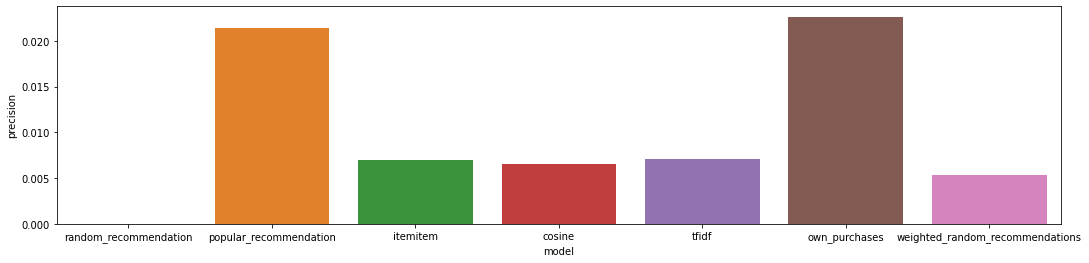

In [16]:
plt.figure(figsize=[18, 4])
sns.barplot(data=models_precision, x='model', y='precision', )
plt.show()

Судя по $Precision@5$ лучше всего себя показывает модель $Popular Recommendations$ и $Own Purchases$ 

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.